<a href="https://colab.research.google.com/github/Deveshq/Msc-Project/blob/main/CZ_Entanglement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entanglement & Bell State Prepration
          (Neutral Atom Quantum Computing Simulation)

> Devesh Kumar          
> MSc Physics-II

In [1]:
#Some general imports

import numpy as np
import matplotlib.pyplot as plt
import qutip
from itertools import product

Some imports from Pulser:

In [2]:
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform, ConstantWaveform
from pulser.simulation import Simulation, SimConfig

### Defining Register


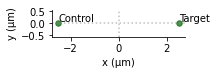

In [3]:
qubits = {'Control': (-2.5,0) , 'Target': (2.5,0) }
reg = Register(qubits)

reg.draw()

### State preparation

In [4]:
def state_prep(sid, basis):
    ids = {'digital': 'ge', 'ground-rydberg': 'rg', 'all': 'rge'}
    
    ket = {k: qutip.basis(len(ids[basis]), i) 
           for i, k in enumerate(ids[basis])}
    
    return qutip.tensor([ket[x] for x in sid])

State preparation sequence:

In [5]:
pi_wf = BlackmanWaveform(200, np.pi)
pi_y = Pulse.ConstantDetuning(pi_wf, 0, -np.pi/2)

In [6]:
def prep_seq(sid, reg):
    global seq
    
    seq = Sequence(reg, Chadoq2)

    #Declare channel
    seq.declare_channel('raman', 'raman_local')
    seq.declare_channel('ryd', 'rydberg_local', 'Control')
    
    if len(sid) != len(reg.qubits):
        raise ValueError('Not a valid state ID.')
    
    seq_dict = {'1':'Target', '0':'Control'}
    
    if sid == 'gg':
        basis = 'all'
        seq.target('Control', 'raman')
    else:
        basis = 'all'
        for i in range(len(reg.qubits)):
            if sid[i] == 'e':
                seq.target(seq_dict[str(i)],'raman')
                seq.add(pi_y,'raman')
        
    prep_state = state_prep(sid, basis)
            
    return prep_state

Preparaed state:

In [7]:
prep_state = prep_seq('ge', reg)

print(prep_state)

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


### Entanglement Sequence

In [8]:
half_pi_wf = BlackmanWaveform(100, np.pi/2)
half_pi_pulse = Pulse.ConstantDetuning(half_pi_wf, 0, -np.pi/2)
half_pi_pulse_d = Pulse.ConstantDetuning(half_pi_wf, 0, np.pi/2)

pi_wf = BlackmanWaveform(200, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

twopi_wf = BlackmanWaveform(300, 2*np.pi)
twopi_pulse = Pulse.ConstantDetuning(twopi_wf, 0, 0)

In [9]:
def CNOT_seq(int_id):

    #State Preparation
    prep_state = prep_seq(int_id, reg)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default = 0)
    
    #Hadamard sequence
    seq.target('Control', 'raman')
    seq.add(half_pi_pulse, 'raman', 'wait-for-all')
    seq.align('raman', 'ryd')
    
    #CNOT sequence:
    seq.target('Target', 'raman')
    seq.add(half_pi_pulse, 'raman', 'wait-for-all')# Wait for state preparation.
    seq.align('raman', 'ryd')
    
    seq.add(pi_pulse, 'ryd')
    seq.target('Target', 'ryd')    # Changes to target qubit
    seq.add(twopi_pulse, 'ryd')
    seq.target('Control', 'ryd')     # Changes back to control qubit
    seq.add(pi_pulse, 'ryd')
    
    seq.align('raman', 'ryd')
    seq.target('Target', 'raman')
    seq.add(half_pi_pulse_d, 'raman')
    
    return prep_state, prep_time

### Visualising sequence



 Visualization for the initial state '01': 




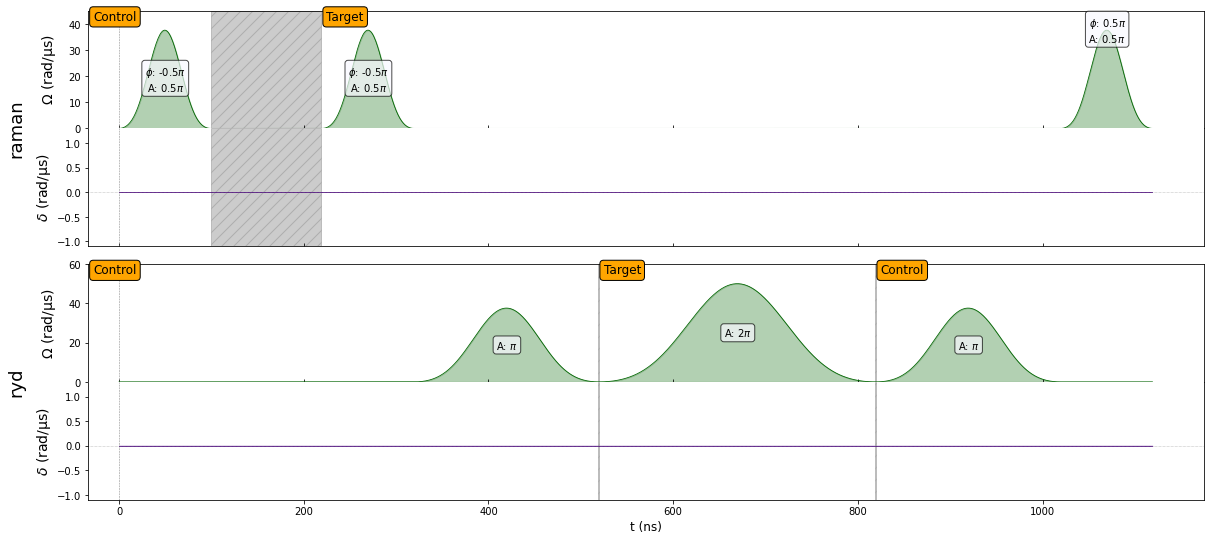


 Prepared state --> Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]

 Preparation time: 0ns 


Channel: raman
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: Control
t: 100->220 | Target: Target | Phase Reference: 0.0
t: 220->320 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: Target
t: 320->1020 | Delay 
t: 1020->1120 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: Target

Channel: ryd
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->320 | Delay 
t: 320->520 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Control
t: 520->520 | Target: Target | Phase Reference: 0.0
t: 520->820 | Pulse(Amp=Blackman(Area: 6.28), Detuning=0 rad/µs, Phase=0) | Targets: Target
t: 820->820 | Target: Control | Phase R

In [10]:
print(f"\n\n Visualization for the initial state '01': \n\n")
prep_state, prep_time = CNOT_seq('gg')
seq.draw(draw_phase_area=True)
print(f'\n Prepared state --> {prep_state}')
print(f'\n Preparation time: {prep_time}ns \n\n')
print(seq)

### Simulating the CNOT-Sequence

For $|B_1⟩ = \frac{|00⟩ + |11⟩}{\sqrt{2}}$


For the Bell state B1: Input- (gg)
Prep state:Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
Prep time:0
counts: Counter({'00': 474, '11': 427, '10': 51, '01': 48})



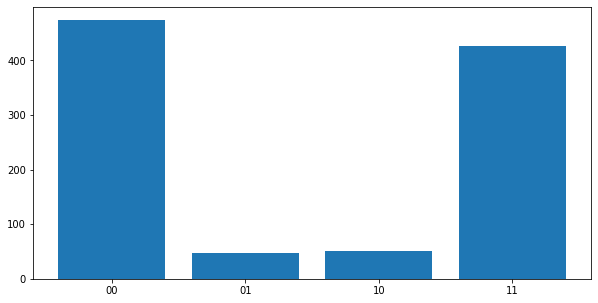

In [24]:
n=1
state = [0]*2

for sid in {'gg'}:
    # State prep
    prep_state, prep_time = CNOT_seq(sid) # constructs seq, prep_state and prep_time
    
    # Construct Simulation instance
    sim = Simulation(seq)
    cfg = SimConfig(noise=('SPAM', 'doppler'), eta = 0.02, temperature = 200, runs = 1000) 
    sim.set_config(cfg)

    res = sim.run()
    
    state[n-1] = res.get_final_state()#reduce_to_basis='digital')
    count = res.sample_final_state(N_samples=1e3)
    
    print(f'\nFor the Bell state B{n}: Input- ({sid})\nPrep state:{prep_state}\nPrep time:{prep_time}\ncounts: {count}\n')
    
    most_freq = {k:v for k,v in count.items() if v>5}
    
    plt.figure(figsize=(10,5))
    plt.bar(list(most_freq.keys()), list(most_freq.values()), width = 0.8)
    plt.xticks()#rotation ='vertical')
    plt.show()
    n +=1 


In [32]:
 state[0]*state[0].dag(), state[0]

(Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.219024   0.         0.         0.        ]
  [0.         0.00272484 0.         0.        ]
  [0.         0.         0.00206116 0.        ]
  [0.         0.         0.         0.18870336]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.468  0.     0.     0.    ]
  [0.     0.0522 0.     0.    ]
  [0.     0.     0.0454 0.    ]
  [0.     0.     0.     0.4344]])


For $|B_2⟩ = \frac{|01⟩ + |10⟩}{\sqrt{2}}$ :


For the Bell state B1: Input- (ge)
Prep state:Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]
Prep time:200
counts: Counter({'10': 463, '01': 448, '00': 75, '11': 14})



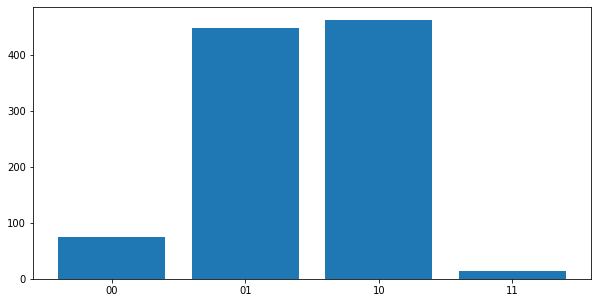

In [33]:
n=1
state = [0]*2

for sid in {'ge'}:
    # State prep
    prep_state, prep_time = CNOT_seq(sid) # constructs seq, prep_state and prep_time
    
    # Construct Simulation instance
    sim = Simulation(seq)
    cfg = SimConfig(noise=('SPAM', 'doppler'), eta = 0.02, temperature = 200, runs = 1000) 
    sim.set_config(cfg)

    res = sim.run()
    
    state[n-1] = res.get_final_state()#reduce_to_basis='digital')
    count = res.sample_final_state(N_samples=1e3)
    
    print(f'\nFor the Bell state B{n}: Input- ({sid})\nPrep state:{prep_state}\nPrep time:{prep_time}\ncounts: {count}\n')
    
    most_freq = {k:v for k,v in count.items() if v>5}
    
    plt.figure(figsize=(10,5))
    plt.bar(list(most_freq.keys()), list(most_freq.values()), width = 0.8)
    plt.xticks()#rotation ='vertical')
    plt.show()
    n +=1 


In [34]:
 state[0]*state[0].dag(), state[0]

(Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[7.1910400e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 1.9009600e-01 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 2.1752896e-01 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6384000e-04]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.0848 0.     0.     0.    ]
  [0.     0.436  0.     0.    ]
  [0.     0.     0.4664 0.    ]
  [0.     0.     0.     0.0128]])

## Analysis

### Probability matrix (need to update this)

We get the probability matrix...


$$
U_{CNOT} =
\begin{bmatrix}
    0.4826 & 0.0440 & 0.0380 & 0.4354 \\
    0.0872 & 0.4615 & 0.4408 & 0.0105 \\
    0.4770 & 0.0442 & 0.0384 & 0.4404 \\
    0.0950 & 0.4457 & 0.4468 & 0.0125 \\
\end{bmatrix}
$$

### Entanglement verification

The value of $F$ larger than $1/2$ is an entangled state. Where $F$ is given by:

$$
F = \frac{1}{2}(P_{00} + P_{11}) + c_1
$$
.

.

.
